In [58]:
import os
import numpy as np
import random
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from utils import relative_path, file_exists


NUM_CHANNELS = 1
TEST_SIZE = 0.05
MIN_FACES_PER_PERSON = 2
DATASET_COMPRESSED_PATH = os.environ.get('DATASET', relative_path('../data/dataset.npy'))


def fetch_dataset():
    lfw_people = fetch_lfw_people(min_faces_per_person=MIN_FACES_PER_PERSON, resize=0.8)
    images = lfw_people.images.reshape(lfw_people.images.shape + (NUM_CHANNELS,))
    images = images / 255.0
#     return train_test_split(images, lfw_people.target, test_size=TEST_SIZE)
    return images, lfw_people.target


def load_dataset():
    if file_exists(DATASET_COMPRESSED_PATH):
        return np.load(DATASET_COMPRESSED_PATH, allow_pickle=True)
    else:
        return fetch_dataset()


# if __name__ == '__main__':
#     dataset = fetch_dataset()
#     np.save(DATASET_COMPRESSED_PATH, dataset)
#     print('Dataset saved to %s' % (DATASET_COMPRESSED_PATH))


In [59]:
dataset = fetch_dataset()

In [60]:
# X_train, X_test, y_train, y_test = dataset
X_train, y_train = dataset

In [114]:
from itertools import cycle

BATCH_SIZE = 256
MAX_PERSON_IMGS_IN_BATCH = 50
MAX_ANCHOR_POS_COUNT_IN_BATCH = 10
SEMIHARD_MARGIN = 0.2

def is_semihard(anchor, pos, neg):
    return np.linalg.norm(anchor - pos) + SEMIHARD_MARGIN > np.linalg.norm(anchor - neg)

def person_image_mapping(images, targets):
    person_images = { person_id: [] for person_id in set(targets) }

    for i in range(0, images.shape[0]):
        person_id = targets[i]
        person_images[person_id].append(images[i])

    return person_images


def triplet_generator(person_image, calc_embedding):
    batch_anchor = []
    batch_pos    = []
    batch_neg    = []
    
    for person in cycle(person_image.keys()):
        pos_tuples = zip(person_image[person], person_image[person][1:])
        person_count = 0

        for anchor_img, pos_img in pos_tuples:
            other_people_imgs = [ imgs for other_person, imgs in person_image.items() if person != other_person ]
            other_people_imgs = [ img for imgs in other_people_imgs for img in imgs ]
            random.shuffle(other_people_imgs)
            anchor_emb = calc_embedding(anchor_img.reshape((1,) + anchor_img.shape))
            anchor_pos_count = 0
            
            for neg_img in other_people_imgs:
                pos_emb = calc_embedding(pos_img.reshape((1,) + pos_img.shape))
                neg_emb = calc_embedding(neg_img.reshape((1,) + neg_img.shape))
                
                if is_semihard(anchor_emb, pos_emb, neg_emb):
                    batch_anchor.append(anchor_img)
                    batch_pos.append(pos_img)
                    batch_neg.append(neg_img)
                    person_count += 1
                    anchor_pos_count += 1
                    
                if len(batch_anchor) == BATCH_SIZE:
                    yield [np.array(batch_anchor), np.array(batch_pos), np.array(batch_neg)]
                    anchor_emb = calc_embedding(anchor_img.reshape((1,) + anchor_img.shape))
                    batch_anchor = []
                    batch_pos    = []
                    batch_neg    = []
                    
                if anchor_pos_count >= MAX_ANCHOR_POS_COUNT_IN_BATCH:
                    break
                    
                if person_count >= MAX_PERSON_IMGS_IN_BATCH:
                    break
                    
            if person_count >= MAX_PERSON_IMGS_IN_BATCH:
                    break

In [9]:
from train import load_model

input_shape = X_train.shape[1:]
facenet_model, base_model = load_model(input_shape)

In [68]:
person_image = person_image_mapping(X_train, y_train)

In [115]:
triplet_gen = triplet_generator(person_image, base_model.predict)
batch = next(triplet_gen)

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_image(img_np):
    plt.imshow(img_np.reshape((img_np.shape[0], img_np.shape[1])), cmap='gray', vmin=0, vmax=1)
    plt.show()

In [81]:
batch = next(triplet_gen)

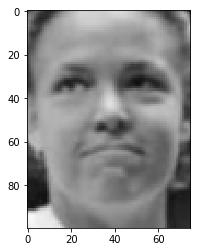

In [123]:
show_image(batch[2][20])